#My Code Of GNSS-RTK


In [2]:
#@title Import relevant modules
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from google.colab import drive
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

#connect the drive and reed the data csv
drive.mount('/content/drive') #connect the drive
train_file = '/content/drive/MyDrive/SADEL/Tirocinio/CSV/sassuolo-modena-bo-afternoon1-sideExt_front-rtk.csv' #the path of file
train_df = pd.read_csv(train_file)
#train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples

test_file = '/content/drive/MyDrive/SADEL/Tirocinio/CSV/sassuolo-modena-bo-morning-side-nortk.csv' #the path of file
test_df = pd.read_csv(test_file)

Mounted at /content/drive


In [ ]:
#@title Use the Rule to Lable dataset
'''
the rule:
  a. acc < 3 good view
  b. acc > 3 && num >= 18 multipath
  c. acc > 3 && num < 18 tunnel
'''
#1.define the algorithm of lable_data.
def label_data(row):
    if row['PACC H'] <= 3:
        return 'good view'
    elif row['PACC H'] > 3 and row['SVs Used'] >= 18:
        return 'multipath'
    elif row['PACC H'] > 3 and row['SVs Used'] < 18:
        return 'tunnel'

#2.modify the lable from string to votre.
mapping = {'good view': [1,0,0],
           'multipath': [0,1,0],
           'tunnel': [0,0,1]}

#3.create lable column
labels = train_df.apply(label_data, axis=1).map(mapping)

#4.write into train_df
train_df['labels'] = labels
display(train_df)

In [4]:
#@title Define the Structure of Nerual Network
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(2,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
#@title Compile and Train Model
x_train = train_df[['PACC H', 'SVs Used']]
y_train = np.stack(train_df['labels'].values)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #optimizer='rmsprop',
model.fit(x_train, y_train, epochs=100, batch_size=32)

In [ ]:
#@title Predict Model
x_test = test_df[['PACC H', 'SVs Used']]
y_pred = model.predict(x_test)

print(y_pred)

In [ ]:
#@title Write preds into Dataset
preds = []
for row in y_pred:
    pred = [0, 0, 0]
    pred[row.argmax()] = 1
    preds.append(pred)
test_df['preds'] = preds

#set option of display
pd.set_option('display.max_rows', None)
display(test_df)

In [8]:
#@title Generate the csv file
test_df.to_csv('test.csv')

<Axes: >

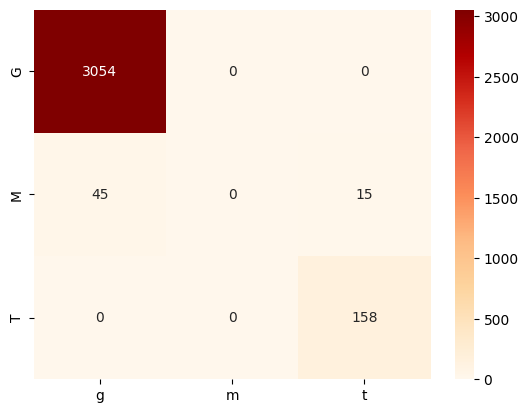

In [13]:
#@title Use the confusion matrix to evaluate the result of prediction

#difine y_true
labels = test_df.apply(label_data, axis=1).map(mapping)
test_df['labels'] = labels
y_true = test_df['labels']
y_pred = test_df['preds']

#format the paramaters y_true and y_pred
y_true = np.array(y_true.tolist())
y_pred = np.array(y_pred.tolist())
y_true = np.argmax(y_true, 1)
y_pred = np.argmax(y_pred, 1)

#define the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

#plot the gragh of confusion matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in "GMT"],
              columns = [i for i in "gmt"])
sn.heatmap(df_cm, annot=True, fmt="d", cmap="OrRd")